# Fine-Tuning Embedding Models

In this cookbook, we demonstrate how to fine-tune open-source embedding models using sentence-transformer and then evaluating its performance. Like always, we'll focus on data-driven approaches to measure and improve retrieval performance.

Imagine you’re building a dating app. Two users fill in their bios:
- “I love coffee.”
- “I hate coffee.”

From a linguistic standpoint, these statements are opposites. But from a recommendation perspective, there’s a case to be made that they belong together. Both are expressing strong food preferences. Both might be ‘foodies’ which is why they mentioned their preferences. 

The point here is subtle, but important: semantic similarity is not the same as task relevance. That’s why fine-tuning your embedding model, even on a small number of labeled pairs, can make a noticeable difference. I’ve often seen teams improve their recall by 10-15% by fine-tuning their embedding models with just a couple hundred examples. 

Whether you’re recommending dating profiles or retrieving security policies, what matters is that the notion of “relevance” is aligned with your application’s goal.

## Requirements

Before starting, ensure you have the following packages installed:

In [ ]:
%pip install langwatch openai chromadb pandas matplotlib datasets

## Setup

Start by setting up LangWatch to monitor your RAG application:

In [ ]:
%pip install langwatch chromadb openai pandas numpy pydantic seaborn

In [80]:
import chromadb
import pandas as pd
import openai
import getpass
import langwatch

# Display settings for better visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

# Initialize OpenAI, LangWatch & HuggingFace
openai.api_key = getpass.getpass('Enter your OpenAI API key: ')
langwatch.api_key = getpass.getpass('Enter your LangWatch API key: ')
huggingface_api_key = getpass.getpass("Enter your Huggingface API key: ")
chroma_client = chromadb.PersistentClient()

## Generating Synthetic Data

In this section, we'll generate synthetic data to simulate a real-world scenario. We'll mimic Ramp's successful approach to fine-tuning embeddings for transaction categorization. Following their case study, we'll create a dataset of transactions objects with associated categories. I've pre-defined some categories and stored them in data/categories.json. Let's load them first and see what they look like.

In [6]:
import json
from rich import print

# Load in pre-defined categories
categories = json.load(open("../data/categories.json"))

# Print the first category
print(categories[0])

{
    'category': 'Software & Licenses',
    'sample_transactions': [
        'Adobe Creative Cloud Annual Subscription',
        'Microsoft 365 Business Premium',
        'Atlassian JIRA License',
        'Zoom Enterprise Plan',
        'AutoCAD Software License'
    ],
    'departments': [
        'Engineering',
        'Marketing',
        'HR',
        'Finance',
        'Legal',
        'IT Operations',
        'Research & Development'
    ]
}

Let's now create a Pydantic Model to represent the transaction data. Following their casestudy, each transaction will be represented as an object containing:

- Merchant name
- Merchant category (MCC)
- Department name
- Location
- Amount
- Memo
- Spend program name
- Trip name (if applicable)

In [7]:
from pydantic import BaseModel, field_validator, ValidationInfo
from typing import Optional
from textwrap import dedent

# A Pydantic model to represent the same transaction data as Ramp
class Transaction(BaseModel):
    merchant_name: str
    merchant_category: list[str]
    department: str
    location: str
    amount: float
    spend_program_name: str
    trip_name: Optional[str] = None
    expense_category: str

    def format_transaction(self):
        return dedent(f"""
        Name : {self.merchant_name}
        Category: {", ".join(self.merchant_category)}
        Department: {self.department}
        Location: {self.location}
        Amount: {self.amount}
        Card: {self.spend_program_name}
        Trip Name: {self.trip_name if self.trip_name else "unknown"}
        """)

    @field_validator("expense_category")
    @classmethod
    def validate_expense_category(cls, v, info: ValidationInfo):
        if not info.context:
            return v

        expected_category = info.context.get("category")

        if v != expected_category:
            raise ValueError(f"Expense category must be '{expected_category}', but got '{v}'")

        return v

Notice that I don't include the expense_category in the format_transaction method, since this is our label. Now that we have a Transaction class, let's load the data and create a list of transactions. I'll use the instructor library to generate data in the format we need.

In [10]:
from openai import AsyncOpenAI
import instructor

client = instructor.from_openai(AsyncOpenAI(api_key=openai.api_key))

async def generate_transaction(category):
    prompt ="""
                Generate a potentially ambiguous business transaction that could reasonably be categorized as {{ category }} or another similar category. The goal is to create transactions that challenge automatic categorization systems by having characteristics that could fit multiple categories.

                Available categories in the system.:
                <categories>
                {% for category_option in categories %}
                    {{ category_option["category"] }}
                {% endfor %}
                </categories>

                The transaction should:
                1. Have the same category as {{ category }}
                2. Use a realistic but non-obvious merchant name (international names welcome), don't use names that are obviously made u
                3. Include a plausible but non-rounded amount with decimals (e.g., $1247.83)
                4. Be difficult to categorize definitively (could fit in multiple categories)
                5. Merchant Category Name(s) should not reference the category at all and should be able to be used for other similar categories if possible.
            """

    return await client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "system", "content": prompt}],
        context={"category": category},
        response_model=Transaction,
    )

We can now generate a large number of transactions using asyncio and our generate_transaction function.

In [11]:
import random
import asyncio

coros = []
for _ in range(326):
    coros.append(generate_transaction(random.choice(categories)['category']))

transactions = await asyncio.gather(*coros)

In [12]:
print(transactions[0])

Transaction(
    merchant_name='Global Tech Solutions',
    merchant_category=['Information Technology Services', 'Miscellaneous'],
    department='IT Department',
    location='San Francisco, CA',
    amount=1575.67,
    spend_program_name='Hardware Upgrade Program',
    trip_name=None,
    expense_category='Hardware & Equipment'
)

Awesome. Now let's create a list of transactions, where each transaction is a dictionary with a "query" and "expected" key.

In [16]:
transactions = [
    {
      "query": transaction.format_transaction(),
      "expected": transaction.expense_category
    }
    for transaction in transactions
]

## Setting up a Vector Database

Let's set up a vector database to store our embeddings of categories. 

In [63]:
import chromadb
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

# Initialize Chroma
client = chromadb.PersistentClient()

# Initialize embeddings
embedding_function = OpenAIEmbeddingFunction(model_name="text-embedding-3-large", api_key=openai.api_key)

# Create collections
base_collection = client.get_or_create_collection(name="base_collection", embedding_function=embedding_function)

# Add documents to both collections
for i, category in enumerate(categories):
    base_collection.add(
        documents=[category['category']],
        ids=[str(i)]
    )

print(f"Created collection with {base_collection.count()} documents.")

Created collection with 27 documents.

## Parametrizing our Retrieval Pipeline

The key to running quick experiments is to parametrize the retrieval pipeline. This makes it easy to swap different retrieval methods as your RAG system evolves. Let's start by defining the metrics we want to track.

**Recall** measures how many of the total relevant items we managed to find. If there are 20 relevant documents in your dataset but you only retrieve 10 of them, that's 50% recall.

**Mean Reciprocal Rank (MRR)** measures how high the first relevant document appears in your results. If the first relevant document is at position 3, the MRR is 1/3.

In [13]:
def calculate_recall(predictions: list[str], ground_truth: list[str]):
    """Calculate the proportion of relevant items that were retrieved"""
    return len([label for label in ground_truth if label in predictions]) / len(ground_truth)

def calculate_mrr(predictions: list[str], ground_truth: list[str]):
    """Calculate Mean Reciprocal Rank - how high the relevant items appear in results"""
    mrr = 0
    for label in ground_truth:
        if label in predictions:
            # Find the position of the first relevant item
            mrr = max(mrr, 1 / (predictions.index(label) + 1))
    return mrr

The case for recall is obvious, since it's the main thing you'd want to track when evaluating your retrieval performance. The case for MRR is more subtle. In Ramp's application, the end-user is shown a number of categories for their transaction and is asked to pick the most relevant one. We want the first category to be the most relevant, so we care about MRR. 

Sidenote: You don't need 100 different metrics. Think about what you care about in your application and track that. You want to keep the signal-to-noise ratio high. 

Before we move on to define both the retrieval function and the evaluation function, let's first structure our data. 

In [64]:
def retrieve(query, collection, k=5):
    """Retrieve documents from a collection based on a query"""
    results = collection.query(query_texts=[query], n_results=k)
    
    # Get the document IDs from the results
    retrieved_docs = results['documents'][0]
    
    return retrieved_docs

# Evaluation function
def evaluate_retrieval(retrieved_ids, expected_ids):
    """Evaluate retrieval performance using recall and MRR"""
    recall = calculate_recall(retrieved_ids, expected_ids)
    mrr = calculate_mrr(retrieved_ids, expected_ids)
    
    return {"recall": recall, "mrr": mrr}


Let's first create a training and evaluation set, so that we can evaluate the performance when we fine-tune our embedding model later fairly.

In [65]:
train_transactions = transactions[: int(0.8 * len(transactions))]
evals_transactions = transactions[int(0.8 * len(transactions)) :]
datasets = [("train", train_transactions), ("evals", evals_transactions)]

Now we can set up our parametrized retrieval pipeline. I'll vary the number of retrieved documents to see how it affects recall and MRR. Note that you can easily vary other parameters (like the embedding models or rerankers) as well with this parametrized pipeline.

In [75]:
def run_evaluation(collections=None, transactions=None,k_values=[1, 3, 5]):
    """Run evaluation across different k values"""
    results = []
    
    for k in k_values:
        for table in collections:
            scores = []
            for transaction in transactions:
                query = transaction['query']
                expected_docs = [transaction['expected']]
                    
                # Retrieve documents
                retrieved_docs = retrieve(query, table, k)
                    
                # Evaluate retrieval
                metrics = evaluate_retrieval(retrieved_docs, expected_docs)
                    
                scores.append({
                    "query": query,
                    "k": k,
                    "recall": metrics["recall"],
                    "mrr": metrics["mrr"]
                })
                
            # Calculate average metrics
            avg_recall = sum(r["recall"] for r in scores) / len(scores)
            avg_mrr = sum(r["mrr"] for r in scores) / len(scores)
                
            results.append({
                "collection": table,
                "k": k,
                "avg_recall": avg_recall,
                "avg_mrr": avg_mrr
            })
                    
    return pd.DataFrame(results)

In [76]:
results_df = run_evaluation(collections=[base_collection], transactions=transactions)
print(results_df)

collection  k  avg_recall   avg_mrr
0  Collection(name=base_collection)  1    0.279141  0.279141
1  Collection(name=base_collection)  3    0.493865  0.368609
2  Collection(name=base_collection)  5    0.607362  0.396677

## Fine-tune embedding models

Moving on, we’ll fine-tune a small open-source embedding model using just 256 synthetic examples. It’s a small set for the sake of speed, but in real projects, you’ll want much bigger private datasets. The more data you have, the better your model will understand the details that general models usually miss.

One big reason to fine-tune open-source models is cost. After training, you can run them on your own hardware without worrying about per-query charges. If you’re handling a lot of traffic, this saves a lot of money fast.

We’ll be using sentence-transformers — it’s easy to train, plays nicely with Hugging Face, and has plenty of community examples if you get stuck. Let's first transform our data in the format that sentence-transformer expects it. 

In [77]:
from sentence_transformers import InputExample, losses
from torch.utils.data import DataLoader
import random

labels = set([train_transaction['expected'] for train_transaction in train_transactions])

finetuning_data = [
    InputExample(
        texts=[transaction['query'], transaction['expected'], negative],
    )
    for transaction in train_transactions 
    for _ in range(2)  # Generate 2 samples per transaction
    for negative in random.sample([label for label in labels if label != transaction['expected']], k=4)  # 4 negatives per sample
]

We’ll use the MultipleNegativesRankingLoss to train our model. This loss function works by maximizing the similarity between a query and its correct document while minimizing the similarity between the query and all other documents in the batch. It’s efficient because every other example in the batch automatically serves as a negative sample, making it ideal for small datasets.

In [78]:
from sentence_transformers import SentenceTransformer

# Load the model, dataloader and loss function
model = SentenceTransformer("BAAI/bge-base-en")
train_dataloader = DataLoader(finetuning_data, batch_size=8, shuffle=True)
train_loss = losses.MultipleNegativesRankingLoss(model)

Now we can start training. If you're done training, you can optionally upload it to HuggingFace. 

In [ ]:
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=3,
    warmup_steps=100,
    output_path="./bge-finetuned"
)

# If you want to save the model to the Hugging Face Hub
"""
model.save("./bge-finetuned")
fine_tuned_model = SentenceTransformer("./bge-finetuned")
fine_tuned_model.push_to_hub("TahmidTapadar/finetuned-bge-base-en", exist_ok=True)
"""

Now we can create a new collection using our fine-tuned embedding model. 

In [81]:
import chromadb.utils.embedding_functions as embedding_functions

huggingface_ef = embedding_functions.HuggingFaceEmbeddingFunction(
    api_key=huggingface_api_key,
    model_name="TahmidTapadar/finetuned-bge-base-en" # replace this with your model
)

# Create collections
finetuned_collection = client.get_or_create_collection(name="finetuned", embedding_function=huggingface_ef)

# Add documents to both collections
for i, category in enumerate(categories):
    finetuned_collection.add(
        documents=[category['category']],
        ids=[str(i)]
    )

print(f"Created collection with {finetuned_collection.count()} documents.")

Created collection with 27 documents.

Let's compare the performance of the two models using our parametrized retrieval pipeline. 

In [82]:
results_df = run_evaluation([base_collection, finetuned_collection], evals_transactions)
print(results_df)

collection  k  avg_recall   avg_mrr
0  Collection(name=base_collection)  1    0.257576  0.257576
1        Collection(name=finetuned)  1    0.727273  0.727273
2  Collection(name=base_collection)  3    0.378788  0.313131
3        Collection(name=finetuned)  3    0.954545  0.830808
4  Collection(name=base_collection)  5    0.545455  0.352525
5        Collection(name=finetuned)  5    0.969697  0.833838

<Axes: xlabel='k'>

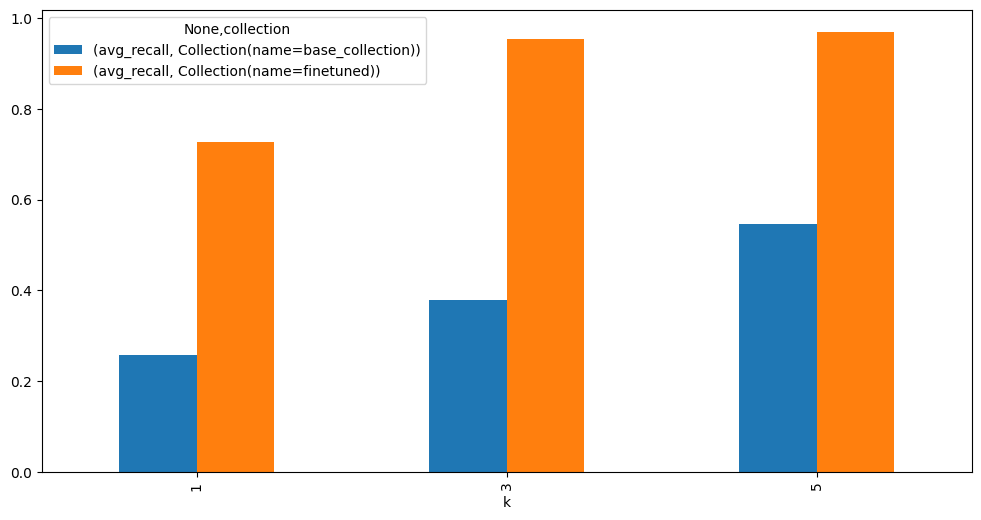

In [92]:
# Convert collection objects to strings
results_df['collection'] = results_df['collection'].astype(str)

# Now create the plot
results_df.pivot(index='k', columns='collection', values=['avg_recall']).plot(kind='bar', figsize=(12, 6))

## Conclusion

We see that the fine-tuned model performs better than the base model on the evaluation set. Like I said at the beginning of this post, I often find teams improve their retrieval significantly by fine-tuning embedding models on their specific data, for their specific application. Note that we didn't even need that much data. A few hundred examples is often enough. 